In [1]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping



2024-11-12 16:46:20.201885: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 16:46:20.204936: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-12 16:46:20.213818: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-12 16:46:20.227957: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-12 16:46:20.232148: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-12 16:46:20.243945: I tensorflow/core/platform/cpu_feature_gu

### Import Data

In [2]:
import pandas as pd

river_df = pd.read_csv('/workspaces/time-series-project-tutorial/acea-water-prediction/River_Arno.csv')
river_df.head()

,Date,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
0,01/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.82
1,02/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.94
2,03/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.11
3,04/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.84
4,05/01/1998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.88


In [3]:
river_df.isnull().sum()
river_df = river_df.dropna()
print(river_df)

            Date  Rainfall_Le_Croci  Rainfall_Cavallina  Rainfall_S_Agata  \
2191  01/01/2004                0.0                 0.0               0.4   
2192  02/01/2004                0.0                 0.0               0.0   
2193  03/01/2004                0.0                 0.0               0.0   
2194  04/01/2004                0.0                 0.0               0.0   
2195  05/01/2004                0.0                 0.0               0.0   
...          ...                ...                 ...               ...   
3469  02/07/2007                0.0                 0.0               0.0   
3470  03/07/2007                0.0                 0.0               0.0   
3471  04/07/2007                0.0                 0.0               0.8   
3472  05/07/2007                0.0                 0.0               0.0   
3473  06/07/2007                0.0                 0.0               0.0   

      Rainfall_Mangona  Rainfall_S_Piero  Rainfall_Vernio  Rainfall_Stia  \

### Format Time Series Date Field

In [4]:
from datetime import datetime

original_date = river_df['Date']
parsed_date = original_date.apply(lambda x: datetime.strptime(x, "%d/%m/%Y"))

# Format to mm/dd/yyyy
river_df['formatted_date'] = pd.to_datetime(river_df['Date'], format="%d/%m/%Y").dt.strftime("%m/%d/%Y")

print(river_df['formatted_date'])


2191    01/01/2004
2192    01/02/2004
2193    01/03/2004
2194    01/04/2004
2195    01/05/2004
           ...    
3469    07/02/2007
3470    07/03/2007
3471    07/04/2007
3472    07/05/2007
3473    07/06/2007
Name: formatted_date, Length: 1276, dtype: object


In [5]:
river_df = river_df.set_index('formatted_date')
river_df = river_df.drop(columns=['Date'])
river_df.head()

,Rainfall_Le_Croci,Rainfall_Cavallina,Rainfall_S_Agata,Rainfall_Mangona,Rainfall_S_Piero,Rainfall_Vernio,Rainfall_Stia,Rainfall_Consuma,Rainfall_Incisa,Rainfall_Montevarchi,Rainfall_S_Savino,Rainfall_Laterina,Rainfall_Bibbiena,Rainfall_Camaldoli,Temperature_Firenze,Hydrometry_Nave_di_Rosano
formatted_date,,,,,,,,,,,,,,,,
01/01/2004,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,8.65,1.84
01/02/2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,7.10,1.93
01/03/2004,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.2,0.0,5.50,1.61
01/04/2004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.55,1.35
01/05/2004,0.0,0.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.70,1.44


In [6]:
river_df.columns

Index(['Rainfall_Le_Croci', 'Rainfall_Cavallina', 'Rainfall_S_Agata',
       'Rainfall_Mangona', 'Rainfall_S_Piero', 'Rainfall_Vernio',
       'Rainfall_Stia', 'Rainfall_Consuma', 'Rainfall_Incisa',
       'Rainfall_Montevarchi', 'Rainfall_S_Savino', 'Rainfall_Laterina',
       'Rainfall_Bibbiena', 'Rainfall_Camaldoli', 'Temperature_Firenze',
       'Hydrometry_Nave_di_Rosano'],
      dtype='object')

## Multivariate Analysis - LSTM 

### Min Max Scaling

#### Function to Min Max scale multiple features

In [8]:
target_columns = ['Hydrometry_Nave_di_Rosano']
feature_columns = river_df.drop(columns=target_columns).columns.tolist()

#target_columns.dtypes

In [9]:
# Ensure X is defined

def prepare_feature_data(df, feature_columns, target_columns, lookback=30):
    """
    Prepare multi-feature sequences for LSTM model
    """
    
    X, y = [], []
    # Scale the features
    scaler_features = MinMaxScaler()
    scaled_features = scaler_features.fit_transform(df[feature_columns])
    
    # Scale the target separately
    scaler_target = MinMaxScaler()
    scaled_target = scaler_target.fit_transform(df[target_columns])
    
    for i in range(len(df) - lookback):
        # Features: take all feature columns for the lookback period
        X.append(scaled_features[i:(i + lookback)])
        # Targets: take all target columns for the prediction point
        y.append(scaled_target[(i + lookback)])
    
    return X, y, scaler_features, scaler_target

# Call the function with debugging
try:
    X, y, scaler_features, scaler_target = prepare_feature_data(river_df, feature_columns, target_columns, lookback=30)
    print(scaler_target)
except ValueError as e:
    print("ValueError encountered:", e)
    # print("river_df shape:", river_df.shape)
    # print("feature_columns:", feature_columns)
    # print("target_columns:", target_columns)
    # print("lookback:", 7)





MinMaxScaler()


#### Define Test Train Split Myself <br>

In [10]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]
test_size = len(X) - train_size
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
#print(y_train)


Train size: 996, Test size: 250


### LSTM Model Multi-Target

In [11]:
from tensorflow.keras.layers import Bidirectional

n_features = len(feature_columns)

model = Sequential([
    # Increase capacity for better pattern recognition
    Bidirectional(LSTM(128, return_sequences=True, input_shape=(30, n_features))),
    Dropout(0.3),
    
    Bidirectional(LSTM(64, return_sequences=True)),
    Dropout(0.3),
    
    Bidirectional(LSTM(32)),
    Dropout(0.3),
    
    Dense(32, activation='relu'),
    Dense(1)
])

# Use Huber loss to handle outliers better
model.compile(optimizer=Adam(learning_rate=0.001), loss='huber')

/usr/local/python/3.12.1/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


#### Define Early Stopping to precvent Overfitting 

In [12]:
# Define early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    patience=5,          # Number of epochs with no improvement before stopping
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)



In [13]:
import numpy as np

# Convert to numpy arrays
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)

# Ensure the shapes are compatible
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Train the model with early stopping
history = model.fit(
    X_train, y_train,
    validation_split=0.2,  # Use 20% of the training data for validation
    epochs=100,            # Set a high number of epochs; early stopping will stop it earlier if needed
    batch_size=32,         # Adjust batch size based on your dataset size
    callbacks=[early_stopping],
    verbose=1              # Print training progress
)

X_train shape: (996, 30, 15)
y_train shape: (996, 1)
Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 11s 141ms/step - loss: 0.0102 - val_loss: 0.0011
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 106ms/step - loss: 0.0037 - val_loss: 0.0017
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 103ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 105ms/step - loss: 0.0028 - val_loss: 0.0023
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 101ms/step - loss: 0.0034 - val_loss: 8.1967e-04
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - loss: 0.0029 - val_loss: 0.0014
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 123ms/step - loss: 0.0029 - val_loss: 0.0011
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 125ms/step - loss: 0.0022 - val_loss: 0.0012
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 112ms/step - loss: 0.0031 - val_loss: 0.0010
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 124ms/step - loss: 0.0030 - val_loss: 9.7039e-04


### Model Predictions
We train the model on the train data and the test data to see how well <br>
we are predicting the training and testing data

In [14]:
train_pred = model.predict(X_train)
test_pred = model.predict(X_test)

print(test_pred)

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
[[ 1.61612816e-02]
 [ 6.18798286e-03]
 [-5.58083877e-04]
 [ 5.31490892e-04]
 [ 3.43596563e-03]
 [ 5.72346710e-03]
 [ 7.70312920e-03]
 [ 9.94000025e-03]
 [ 1.24532003e-02]
 [ 1.60742477e-02]
 [ 1.91400498e-02]
 [ 2.16893554e-02]
 [ 2.33487990e-02]
 [ 2.14326251e-02]
 [ 2.36372426e-02]
 [ 2.55022403e-02]
 [ 2.68510673e-02]
 [ 2.80356780e-02]
 [ 2.95899138e-02]
 [ 3.03885713e-02]
 [ 3.04427259e-02]
 [ 2.98232473e-02]
 [ 3.05048004e-02]
 [ 3.18571925e-02]
 [ 2.59843655e-02]
 [ 3.85646597e-02]
 [ 3.61217186e-02]
 [ 1.62300229e-01]
 [ 3.00729096e-01]
 [ 3.77597332e-01]
 [ 3.18082482e-01]
 [ 2.61337668e-01]
 [ 2.05818683e-01]
 [ 1.59655303e-01]
 [ 1.32929578e-01]
 [ 1.17315009e-01]
 [ 1.08284660e-01]
 [ 1.02393538e-01]
 [ 9.87640321e-02]
 [ 1.00291304e-01]
 [ 1.02551579e-01]
 [ 1.42416537e-01]
 [ 1.34864748e-01]
 [ 1.41100079e-01]
 [ 1.60156995e-01]
 [ 1.51060864e-01]
 [ 4.27777082e-01]
 [ 3.85082394e-01]
 [ 3.25685

### Convert back to normal scale

In [15]:
# Inverse transform predictions
train_pred = scaler_target.inverse_transform(train_pred)
test_pred = scaler_target.inverse_transform(test_pred)
y_train_orig = scaler_target.inverse_transform(y_train)
y_test_orig = scaler_target.inverse_transform(y_test)



### Evaluate Loss

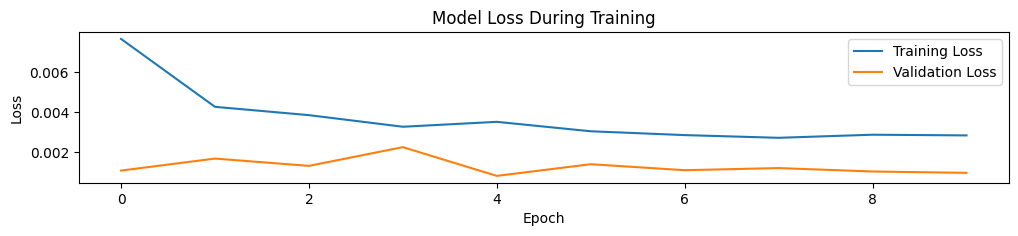

In [16]:
import matplotlib.pyplot as plt


# Create visualizations
plt.figure(figsize=(12, 9))

# Plot 1: Training Loss
plt.subplot(4, 1, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Evaluate Progress

In [17]:
def evaluate_regression_lstm(y_true, y_pred):
    # R² score (1.0 is perfect prediction)
    r2 = r2_score(y_true, y_pred)
    
    # Mean Absolute Error
    mae = mean_absolute_error(y_true, y_pred)
    
    # Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    
    # Custom accuracy metric for regression (as percentage)
    # Using 1 - normalized MAE as a proxy for accuracy
    #accuracy = (1 - mae / (y_true.max() - y_true.min())) * 100
    
    print("\nRegression Metrics:")
    print(f"R² Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    #print(f"Accuracy (based on normalized MAE): {accuracy:.2f}%")
    
    return r2, mae, rmse

### Evaluate 3 Targets

In [18]:
evaluate_regression_lstm(y_test_orig, test_pred)


Regression Metrics:
R² Score: 0.3421
MAE: 0.1922
RMSE: 0.2589


(0.34206246856109945, 0.19217064717292784, 0.25891674411312116)

## Plot Residuals - Actual vs Predicted

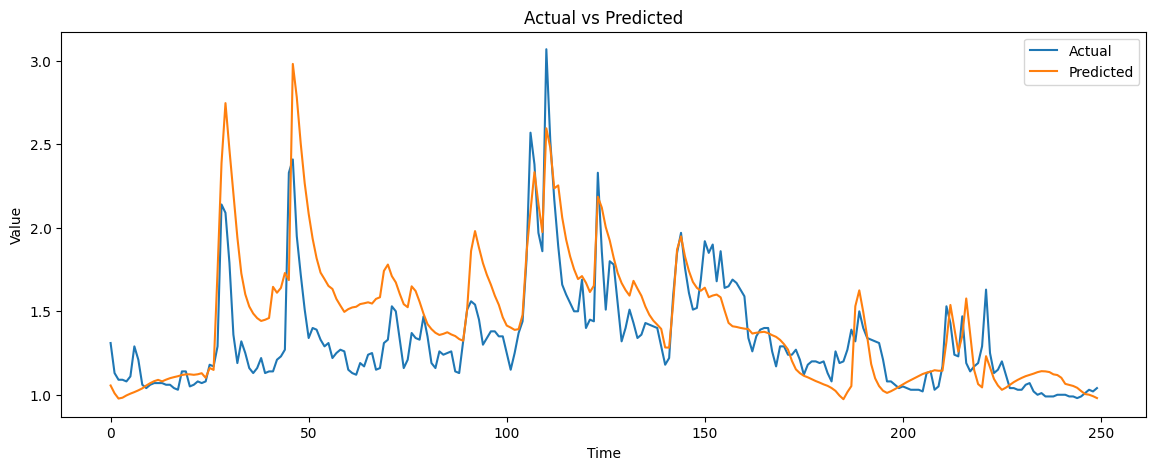

In [19]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_true, y_pred, title='Actual vs Predicted'):
    plt.figure(figsize=(14, 5))
    plt.plot(y_true, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

# Assuming y_test and test_pred are defined
plot_actual_vs_predicted(y_test_orig, test_pred)


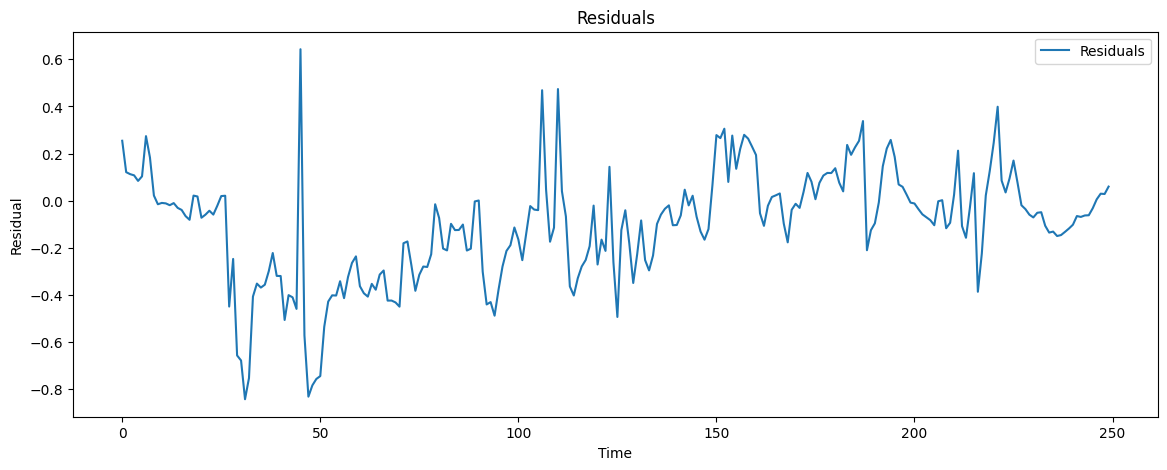

: 

In [20]:
def plot_residuals(y_true, y_pred, title='Residuals'):
    residuals = y_true - y_pred
    plt.figure(figsize=(14, 5))
    plt.plot(residuals, label='Residuals')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Residual')
    plt.legend()
    plt.show()
    
    
plot_residuals(y_test_orig, test_pred, title='Residuals')

## Find Optimal Learning Rate 

### Find Optimal Learning Rate 

In [ ]:
def find_optimal_lr(model, X_train, y_train):
    lr_schedule = np.logspace(-4, -2, 100)  # Test from 0.0001 to 0.01
    losses = []
    
    for lr in lr_schedule:
        model.optimizer.learning_rate.assign(lr)
        loss = model.train_on_batch(X_train[:32], y_train[:32])
        losses.append(loss)
        
    best_lr = lr_schedule[np.argmin(losses)]
    return best_lr

find_optimal_lr(model, X_train, y_train)